In [3]:
import os
import time
from astropy.modeling import models, fitting
from astropy.table import Table
from matplotlib import patches
from scipy import stats
from skimage.transform import resize
from photutils import CircularAperture, CircularAnnulus
from usid_processing import parallel_compute
from functools import partial

import galsim

from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '4'})
rcParams.update({'xtick.major.width': '1.'})
rcParams.update({'xtick.minor.pad': '5.0'})
rcParams.update({'xtick.minor.size': '4'})
rcParams.update({'xtick.minor.width': '0.8'})
rcParams.update({'ytick.major.pad': '5.0'})
rcParams.update({'ytick.major.size': '4'})
rcParams.update({'ytick.major.width': '1.'})
rcParams.update({'ytick.minor.pad': '5.0'})
rcParams.update({'ytick.minor.size': '4'})
rcParams.update({'ytick.minor.width': '0.8'})
rcParams.update({'font.size': 14})
rcParams.update({'legend.fontsize': 14})
rcParams.update({'legend.title_fontsize': 16})
rcParams.update({'axes.titlesize': 16})

from utils import *

############################################
# Setup
############################################

# Fitting Parameter
n_cpu = 3
RUN_FITTING = True
print_progress = True
draw = True
save = False
use_SE_seg = False
mask_strip = True
wid_strip, n_strip = 5, 13

dir_name = "./real"

In [4]:
# Image Parameter
image_size = 600
patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0 = 800, 1800, 1800, 2800  # image coords

pixel_scale = 2.5                                # arcsec/pixel
psf_pixel_scale = 1.5                            # arcsec/pixel

# PSF Parameters
beta_psf = 10                                     # moffat beta, in arcsec
fwhm = 2.28 * pixel_scale                         # moffat fwhm, in arcsec

gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1)  # moffat core width, in arcsec
gamma_pix = gamma / pixel_scale                  # moffat core width, in pix

n = 3                     # true power index
frac = 0.3                 # fraction of power law component
theta_t = 5.                # radius at which power law is flattened, in arcsec

theta_t_pix = theta_t/pixel_scale          # flattened radius, in pix
theta_t_psf_pix = theta_t/psf_pixel_scale  # flattened radius in psf, in pix
a = (theta_t_psf_pix)**n                   # normalization

noise_variance = 10                        # sky variance
mu = 884                                   # sky mean
sigma = np.sqrt(noise_variance)            # sky stddev

mu: 884.42 , std: 4.00 , ZP: 27.10 , pix_scale: 2.50


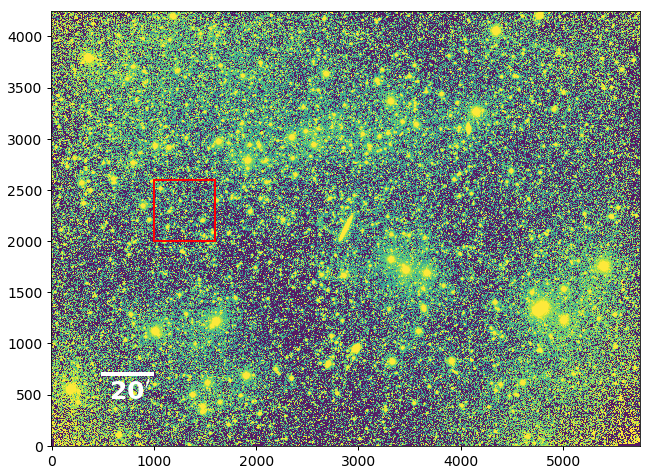

In [5]:
############################################
# Read
############################################

hdu = fits.open("./coadd_SloanR_NGC_5907.fits")[0]
seg_map = fits.open("./SE_APASS/coadd_SloanR_NGC_5907_seg.fits")[0].data

data = hdu.data
header = hdu.header
seeing = 2.5

mu, std, = np.float(hdu.header["BACKVAL"]), 4 
ZP, pix_scale = np.float(hdu.header["REFZP"]), np.float(hdu.header["PIXSCALE"])
print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, std, ZP, pix_scale))


def crop_image(data, seg_map, bounds, weight_map=None, draw=False):
    patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = bounds
    patch_xmin, patch_ymin = coord_Im2Array(patch_Xmin, patch_Ymin)
    patch_xmax, patch_ymax = coord_Im2Array(patch_Xmax, patch_Ymax)

    patch = np.copy(data[patch_xmin:patch_xmax, patch_ymin:patch_ymax])
    seg_patch = np.copy(seg_map[patch_xmin:patch_xmax, patch_ymin:patch_ymax])
    
    if draw:
        fig, ax = plt.subplots(figsize=(12,8))       
        plt.imshow(data, vmin=mu, vmax=mu+10*std, norm=norm1, origin="lower", cmap="viridis",alpha=0.9)
        if weight_map is not None:
            plt.imshow(data*weight_map, vmin=mu, vmax=mu+10*std, norm=norm1, origin="lower", cmap="viridis",alpha=0.3)
        plt.plot([500,980],[700,700],"w",lw=4)
        plt.text(560,450, r"$\bf 20'$",color='w', fontsize=25)
        rect = patches.Rectangle((patch_Xmin,patch_Ymin), bounds[2]-bounds[0], bounds[3]-bounds[1],
                                 linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
        
    return patch, seg_patch

pad = ((patch_Xmax0-patch_Xmin0)-image_size)//2
patch_Xmin, patch_Ymin = patch_Xmin0+pad, patch_Ymin0+pad
patch_Xmax, patch_Ymax = patch_Xmax0-pad, patch_Ymax0-pad

image_bounds = (patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax)
patch, seg_patch = crop_image(data, seg_map, image_bounds, draw=True)

def crop_catalog(cat, bounds, keys=("X_IMAGE", "Y_IMAGE")):
    Xmin, Ymin, Xmax, Ymax = bounds
    A, B = keys
    crop = (cat[A]>=Xmin) & (cat[A]<=Xmax) & (cat[B]>=Ymin) & (cat[B]<=Ymax)
    return cat[crop]

# Read measurement
SE_cat_full = Table.read("./SE_APASS/coadd_SloanR_NGC_5907.cat", format="ascii.sextractor")
SE_cat_full["RMAG_AUTO"] = -2.5*np.log10(SE_cat_full["FLUX_AUTO"]) + ZP
SE_cat = crop_catalog(SE_cat_full, bounds=(patch_Xmin,patch_Ymin,patch_Xmax,patch_Ymax))
SE_cat = SE_cat[SE_cat['RMAG_AUTO']>=15]   # For faint star > 15 mag, use SE flux (not to be modeled)

# Read measurement
table_res_Rnorm = Table.read("./Rnorm_8pix_15mag_p2.txt", format="ascii")
table_res_Rnorm = crop_catalog(table_res_Rnorm, 
                               bounds=(patch_Xmin-25,patch_Ymin-25,patch_Xmax+25,patch_Ymax+25))


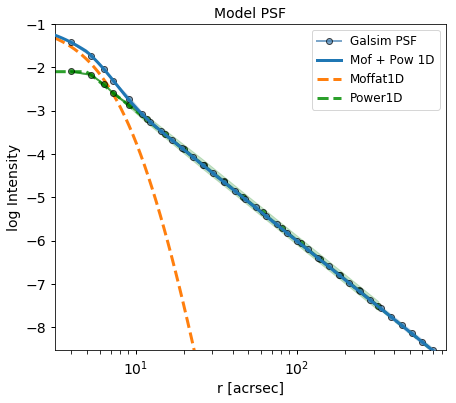

In [6]:
def Generate_PSF_pow_Galsim(contrast, n=n, theta=theta_t, psf_scale=psf_pixel_scale, 
                            psf_size=None, min_psf_size=None, max_psf_size=None,
                            x_interpolant="lanczos3", k_interpolant="lanczos3"):
    if psf_size is None:
        a = (theta_t/psf_scale)**n
        opt_psf_size = 2 * int((contrast * a) ** (1./n))
        opt_psf_size = round_good_fft(opt_psf_size)
        psf_size = max(min_psf_size, min(opt_psf_size, max_psf_size))

    cen_psf = ((psf_size-1)/2., (psf_size-1)/2.)
    yy_psf, xx_psf = np.mgrid[:psf_size, :psf_size]

    psf_model = trunc_power2d(xx_psf, yy_psf, n, cen=cen_psf, theta0=theta_t/psf_scale, I_theta0=1) 
    image_psf = galsim.ImageF(psf_model)
    
    psf_pow = galsim.InterpolatedImage(image_psf, flux=1, scale=psf_scale,
                                       x_interpolant=x_interpolant, k_interpolant=k_interpolant)
    return psf_pow, psf_size

# Define the Power PSF profile, one for making truth in galsim, one for display.
psf_pow_1, psf_size_1 = Generate_PSF_pow_Galsim(contrast=1e4, n=n, 
                                                psf_size=512,
                                                psf_scale=psf_pixel_scale)
psf_pow_2, psf_size_2 = Generate_PSF_pow_Galsim(contrast=1e6, n=n,
                                                psf_size=image_size*2, 
                                                psf_scale=psf_pixel_scale)

# Define the Moffat PSF profile.
gsparams = galsim.GSParams(folding_threshold=1e-7)
psf_mof = galsim.Moffat(beta=beta_psf, flux=1., fwhm=fwhm, gsparams=gsparams) # in arcsec

if draw:
    star_psf_2 = (1-frac) * psf_mof + frac * psf_pow_2 
    
    img_pow_2 = psf_pow_2.drawImage(scale=pixel_scale, method="no_pixel").array
    img_gs_2 = star_psf_2.drawImage(nx=image_size, ny=image_size, scale=pixel_scale, method="no_pixel").array
    
    plt.figure(figsize=(7,6))
    r = np.logspace(0.1,2.5,100)
    c_mof2Dto1D =  1./(beta_psf-1) * 2*math.sqrt(np.pi) * gamma_pix * Gamma(beta_psf) / Gamma(beta_psf-1./2) 
    comp1 = moffat1d_normed(r, gamma=gamma_pix, alpha=beta_psf) / c_mof2Dto1D

    c_pow2Dto1D = np.pi * theta_t_pix * (n-1) / (n-2)
    comp2 = trunc_power1d_normed(r, n, theta_t_pix) / c_pow2Dto1D

    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(frac*img_pow_2, pix_scale=pixel_scale, seeing=2.5, 
                                                 core_undersample=True,xunit="arcsec", yunit="intensity", color="g")
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_gs_2, pix_scale=pixel_scale, seeing=2.5,  
                                                 core_undersample=True,xunit="arcsec", yunit="intensity", label="Galsim PSF")

    plt.plot(r*pixel_scale, np.log10((1-frac) * comp1 + comp2 * frac), ls="-", lw=3, label="Mof + Pow 1D",zorder=5)
    plt.plot(r*pixel_scale, np.log10((1-frac) * comp1), ls="--", lw=3, label="Moffat1D",zorder=1)
    plt.plot(r*pixel_scale, np.log10(comp2 * frac), ls="--",lw=3,  label="Power1D")

    plt.xscale("log")
    plt.axvline(theta_t_pix,color="k",ls="--")
    plt.title("Model PSF",fontsize=14)
    
    plt.legend(fontsize=12)
    plt.ylim(np.log10(z_rbin[-1]),-1)
    if save:
        plt.savefig("%s/Model.png"%dir_name,dpi=150)
        plt.close()

# of medium bright (flux:3.2e+04~1e+06) stars: 56 
# of very bright (flux>1e+06) stars : 9
Crowded fields with bright stars > 50, truth and mock will be generated in parallel.


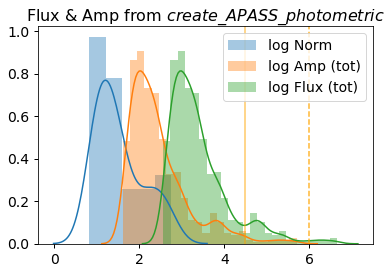

In [12]:
############################################
# Distribution
############################################

# Generate Grid
yy, xx = np.mgrid[:image_size, :image_size]
cen = ((image_size-1)/2., (image_size-1)/2.)

# Read measurement
star_pos1 = np.vstack([SE_cat['X_IMAGE'],SE_cat['Y_IMAGE']]).T - [patch_Xmin, patch_Ymin]
Flux1 = np.array(SE_cat['FLUX_AUTO'])
star_pos2 = np.vstack([table_res_Rnorm['X_IMAGE'],table_res_Rnorm['Y_IMAGE']]).T - [patch_Xmin, patch_Ymin]

sky_local = np.median(table_res_Rnorm['sky'].data)
z_norm = table_res_Rnorm['mean'].data - sky_local   # <15 mag
Amp_pow = z_norm * (8/theta_t_pix)**n
Flux_pow = power2d_Amp2Flux(n, theta_t_pix, Amp=Amp_pow)
Flux2 = Flux_pow / frac

# Thresholds affecting speed and accuracy depending on the
# actual PSF, noise level, and magnitude distribution of stars.
# Non-bright stars are rendered with moffat only in advance.
# Very bright stars are rendered in real space.
F_bright = 3e4
F_verybright = 1e6

out_of_field = np.logical_or.reduce((star_pos2<-10)|(star_pos2>image_size+10), axis=1) \
                & (Flux2>F_bright) & (Flux2<F_verybright)
z_norm = z_norm[~out_of_field]
star_pos2 = star_pos2[~out_of_field]
Flux2 = Flux2[~out_of_field]

star_pos = np.vstack([star_pos1, star_pos2])
Flux = np.concatenate([Flux1, Flux2])

# Convert Flux to Astropy Moffat Amplitude (pixel)
Amps = np.array([moffat2d_Flux2Amp(gamma_pix, beta_psf, Flux=(1-frac)*F) for F in Flux])

bright = Flux > F_bright
verybright = Flux > F_verybright
medbright = bright & (~verybright)
num_medbright = len(Flux[medbright])
num_verybright = len(Flux[verybright])
print("# of medium bright (flux:%.2g~%.2g) stars: %d "%(Flux[bright].min(), Flux[verybright].min(), num_medbright))
print("# of very bright (flux>%.2g) stars : %d"%(Flux[verybright].min(), num_verybright))

# Rendering stars in parallel if number of bright stars exceeds 50
if num_medbright < 50:
    print("Not many bright stars, truth and mock will be generated in serial.")
    parallel = False 
else: 
    parallel = True
    print("Crowded fields with bright stars > 50, truth and mock will be generated in parallel.")

    def map2d(f, xx, yy):
        return f(xx,yy)

    p_map2d = partial(map2d, xx=xx, yy=yy)

if draw:
    import seaborn as sns
    sns.distplot(np.log10(z_norm),label="log Norm")
    sns.distplot(np.log10(Amps),label="log Amp (tot)")
    Amp_pow_s = power2d_Flux2Amp(n, theta_t_pix, Flux=frac*Flux)                     
    sns.distplot(np.log10(Flux),label="log Flux (tot)")
    plt.axvline(np.log10(F_bright), color="orange", ls="-",alpha=0.6)
    plt.axvline(np.log10(F_verybright), color="orange", ls="--",alpha=0.8)
    plt.title("Flux & Amp from $create{\_}APASS{\_}photometric$")
    plt.legend()

In [13]:
############################################
# Setup Image
############################################

# Setup the noise background
def make_noise_image(image_size, noise_var, random_seed=42):
    noise_image = galsim.ImageF(image_size, image_size)
    rng = galsim.BaseDeviate(random_seed)
    gauss_noise = galsim.GaussianNoise(rng, sigma=math.sqrt(noise_var))
    noise_image.addNoise(gauss_noise)  
    return noise_image.array

print("Generate noise background w/ stddev = %.2g."%sigma)
noise_image = make_noise_image(image_size, noise_variance)

# Shift center for the purpose pf accuracy (by default galsim round to integer!)
def get_center_offset(pos):
    x_pos, y_pos = pos[0] + 1, pos[1] + 1 
    x_nominal = x_pos + 0.5
    y_nominal = y_pos + 0.5
    ix_nominal = int(math.floor(x_nominal+0.5))
    iy_nominal = int(math.floor(y_nominal+0.5))
    dx = x_nominal - ix_nominal
    dy = y_nominal - iy_nominal
    offset = galsim.PositionD(dx,dy)
    return (ix_nominal, iy_nominal), offset  

# Auxciliary function of drawing, practically devised to facilitate parallelization.
def draw_star(k, star_pos, Flux, psf_star, psf_size, full_image):
    """ Draw star #k at position star_pos[k] with Flux[k], using a combined PSF (psf_star) on full_image"""
    stamp, bounds = get_stamp_bounds(k, star_pos, Flux, psf_star, psf_size, full_image)
    full_image[bounds] += stamp[bounds]

def get_stamp_bounds(k, star_pos, Flux, psf_star, psf_size, full_image):
    """ Get stamp and boundary of star #k at position star_pos[k] with Flux[k], using a combined PSF (psf_star) on full_image"""
    pos, flux = star_pos[k], Flux[k]       
    star = psf_star.withFlux(flux)

    # Account for the fractional part of the position
    (ix_nominal, iy_nominal), offset = get_center_offset(pos)

    stamp = star.drawImage(nx=psf_size, ny=psf_size, scale=pixel_scale, offset=offset, method='no_pixel')
    stamp.setCenter(ix_nominal, iy_nominal)
    
    bounds = stamp.bounds & full_image.bounds
    
    return stamp, bounds
    
# Setup the base image for faint stars (Moffat only):
def make_base_image(image_size, star_pos, Flux):
    if len(star_pos) == 0:
        return np.zeros((image_size, image_size))
    start = time.time()
    full_image0 = galsim.ImageF(image_size, image_size)
    
    # draw faint stars in Moffat with galsim in Fourier space   
    for k in range(len(star_pos)):
        draw_star(k, star_pos=star_pos, Flux=Flux,
                  psf_star=psf_mof, psf_size=64, full_image=full_image0)

    image_gs0 = full_image0.array
    end = time.time()
    print("Total Time: %.3fs"%(end-start))
    return image_gs0

print("Generate base image of faint stars (flux < %.2g)."%(Flux[~bright].max()))
image_gs0 = make_base_image(image_size, star_pos=star_pos[~bright], Flux=Flux[~bright])

image = patch.copy()

Generate noise background w/ stddev = 3.2.
Generate base image of faint stars (flux < 2.9e+04).
Total Time: 0.282s


Mask inner regions of stars (threshold: S/N = 2.5)
Use sky strips crossing very bright stars


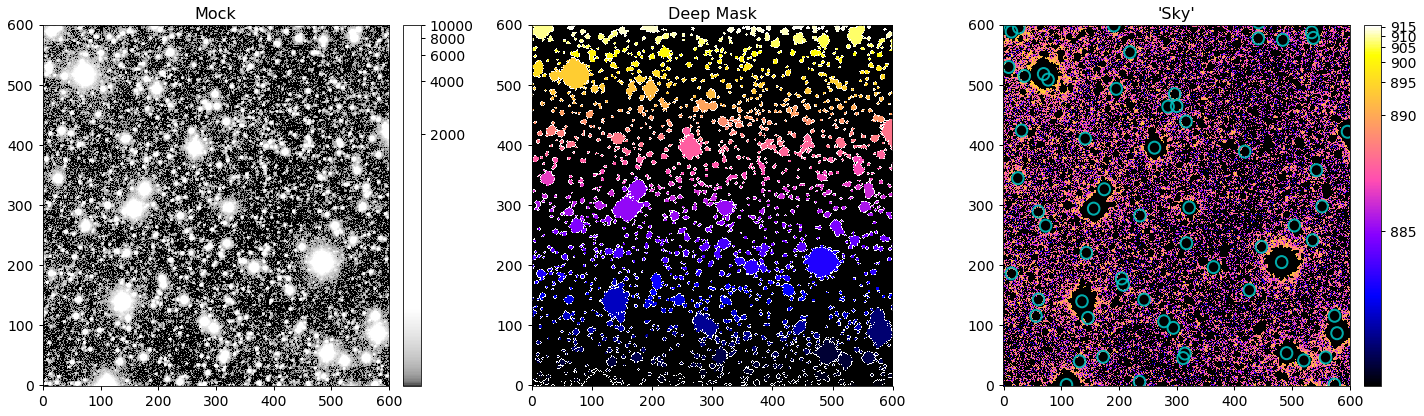

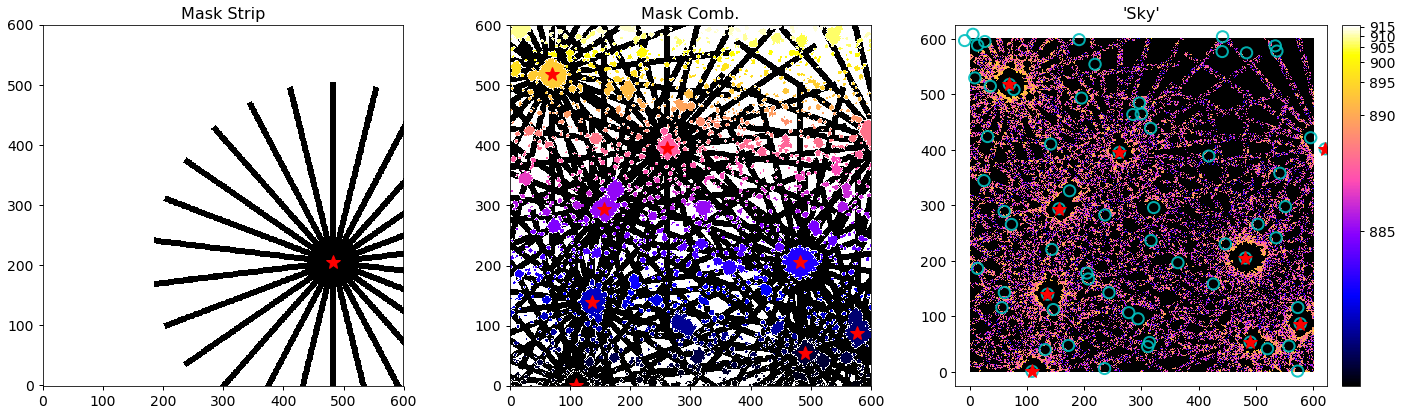

In [14]:
############################################
# Make Mask
############################################

# Make mask map for fitting
if use_SE_seg:
    print("Mask inner regions of stars. Use segmentation based on APASS")
    seg_map = seg_patch.copy()
    for i in range(5):
        seg_map = morphology.dilation(seg_map)
    mask_deep = (seg_map!=0)
else:
    print("Mask inner regions of stars (threshold: S/N = 2.5)")
    mask_deep, seg_map = make_mask_map(image, sn_thre=2.5, b_size=25, n_dilation=1)

if draw:
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,6))
    im1 = ax1.imshow(image, origin='lower', cmap='gray', norm=norm1, vmin=mu, vmax=1e4, aspect='auto')
    ax1.set_title("Mock")
    colorbar(im1)

    ax2.imshow(seg_map, origin="lower", cmap="gnuplot2")
    ax2.set_title("Deep Mask")

    image2 = image.copy()
    image2[mask_deep] = 0
    im3 = ax3.imshow(image2, cmap='gnuplot2', norm=norm2, vmin=mu, vmax=mu+10*sigma, origin='lower', aspect='auto') 
    ax3.set_title("'Sky'")
    colorbar(im3)

    aper = CircularAperture(star_pos[bright], r=10)
    aper.plot(color='c',lw=2,label="",alpha=0.9, axes=ax3)

    plt.tight_layout()
    if save:
        plt.savefig("%s/Mask.png"%dir_name,dpi=150)
        plt.close()

if mask_strip:
    print("Use sky strips crossing very bright stars")
    mask_strip_s = make_mask_strip(image_size, star_pos[verybright], Flux[verybright], 
                                   width=wid_strip, n_strip=n_strip, dist_strip=300)
    mask_strip_all = ~np.logical_or.reduce(mask_strip_s)
    seg_comb = seg_map.copy()
    seg_comb[mask_strip_all&(seg_map==0)] = seg_map.max()+1
    mask_comb = (seg_comb!=0)

    if draw:
        fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,6))
        ax1.imshow(mask_strip_s[-1], origin="lower", cmap="gray_r")
        ax1.plot(star_pos[Flux.argsort()][-1][0], star_pos[Flux.argsort()][-1][1], "r*",ms=15)
        ax1.set_title("Mask Strip")

        ax2.imshow(seg_comb, origin="lower", cmap="gnuplot2")
        ax2.plot(star_pos[verybright][:,0], star_pos[verybright][:,1], "r*",ms=15)
        ax2.set_xlim(0,image_size)
        ax2.set_ylim(0,image_size)
        ax2.set_title("Mask Comb.")

        image3 = image.copy()
        image3[mask_comb] = 0
        im3 = ax3.imshow(image3, cmap='gnuplot2', norm=norm1, aspect='auto', vmin=mu, vmax=mu+10*sigma, origin='lower') 
        ax3.plot(star_pos[verybright][:,0], star_pos[verybright][:,1], "r*",ms=15)
        ax3.set_xlim(-25,image_size+25)
        ax3.set_ylim(-25,image_size+25)
        ax3.set_title("'Sky'")
        colorbar(im3)
        
        aper = CircularAperture(star_pos[bright], r=10)
        aper.plot(color='c',lw=2,label="",alpha=0.9, axes=ax3)

        plt.tight_layout()
        if save:
            plt.savefig("%s/Mask_strip.png"%dir_name,dpi=150)
            plt.close()

            

884.7814645576182 2.917818820557955
0.6986258449444047 883.1082535170492 2.394963963300638


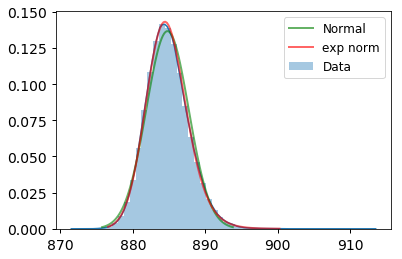

In [32]:
plt.figure(figsize=(6,4))
z_sky = image[~mask_comb]
sns.distplot(z_sky, label='Data')

mu_fit, std_fit = stats.norm.fit(z_sky)
print(mu_fit, std_fit)
d_mod = stats.norm(loc=mu_fit, scale=std_fit)
x = np.linspace(d_mod.ppf(0.001), d_mod.ppf(0.999), 100)
plt.plot(x, d_mod.pdf(x), 'g-', lw=2, alpha=0.6, label='Normal')

K_fit, mu_fit, std_fit = stats.exponnorm.fit(z_sky)
print(K_fit, mu_fit, std_fit)
d_mod2 = stats.exponnorm(loc=mu_fit, scale=std_fit, K=K_fit)
x = np.linspace(d_mod2.ppf(0.001), d_mod2.ppf(0.9999), 100)
plt.plot(x, d_mod2.pdf(x), 'r-', lw=2, alpha=0.6, label='exp norm')

plt.legend(fontsize=12)


Total Time: 0.156s


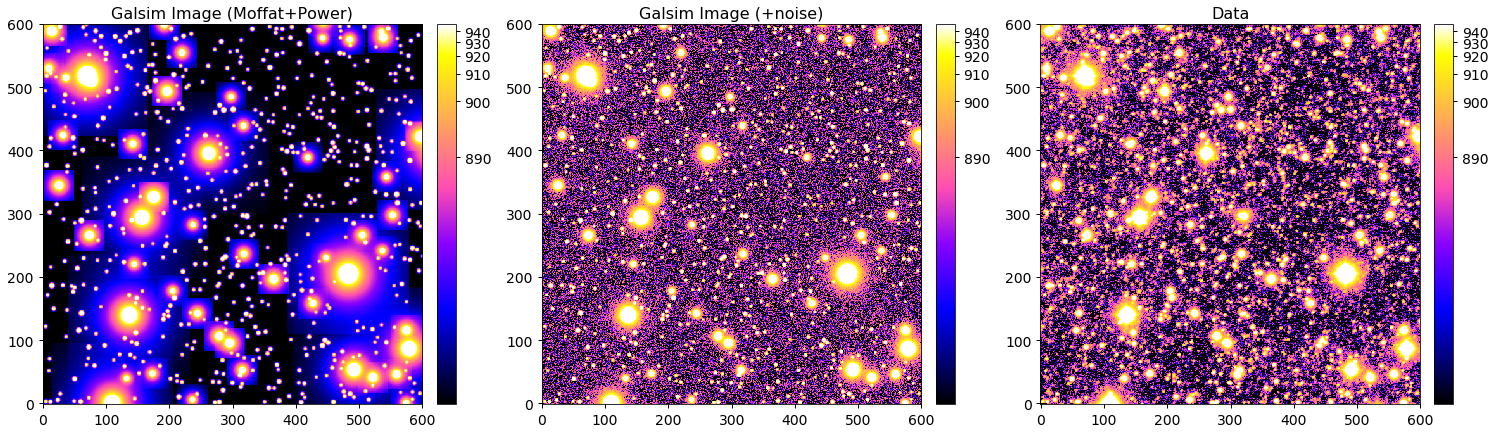

In [11]:
############################################
# Generate Image
############################################

def generate_image_galsim_norm(frac, n, mu, sigma,
                               star_pos=star_pos, 
                               norm=z_norm,
                               image_size=image_size,
                               min_psf_size=32, 
                               max_psf_size=384,
                               parallel=False):
    
    psf_pow, psf_size = Generate_PSF_pow_Galsim(contrast=1e4, n=n, 
                                                psf_scale=pixel_scale, psf_size=None,  
                                                min_psf_size=min_psf_size, max_psf_size=max_psf_size,
                                                x_interpolant="lanczos3", k_interpolant="lanczos3")    
    # Setup the canvas
    full_image = galsim.ImageF(image_size, image_size)
    
    # Draw medium bright stars with galsim in Fourier space
    psf_star = (1-frac) * psf_mof + frac * psf_pow               
    
    # Recompute flux for stars < 15 mag:
    Amp_pow = norm * (8/theta_t_pix)**n
    Flux_pow = power2d_Amp2Flux(n, theta_t_pix, Amp=Amp_pow)
    Flux2 = Flux_pow / frac
 
    Flux = np.concatenate([Flux1, Flux2])
    
    if not parallel:
        # Draw in serial
        for k in range(num_medbright):
            draw_star(k, star_pos=star_pos[medbright], Flux=Flux[medbright],
                      psf_star=psf_star, psf_size=psf_size,
                      full_image=full_image)
    else:
        # Draw in parallel, automatically back to serial computing if too few jobs 
        p_get_stamp_bounds = partial(get_stamp_bounds,
                                     star_pos=star_pos[medbright],
                                     Flux=Flux[medbright],
                                     psf_star=psf_star,
                                     psf_size=psf_size,
                                     full_image=full_image)
        
        results = parallel_compute(np.arange(num_medbright), p_get_stamp_bounds, 
                                   lengthy_computation=False, verbose=False)

        for (stamp, bounds) in results:
            full_image[bounds] += stamp[bounds]
           
    # Draw very bright star in real space / Fourier space       
    if (n < 2.5) | (image_size<500):
        draw_real = True
    else: 
        draw_real = False
    if draw_real:
        # Draw very bright star (if highter cost in FFT) in real space
        image_gs = full_image.array
        for (pos, flux) in zip(star_pos[verybright], Flux[verybright]):
            p2d_vb = trunc_power2d(xx, yy, n, cen=(pos[0],pos[1]),
                                   theta0=theta_t_pix, I_theta0=frac*flux * (n-2)/n /theta_t_pix**2/np.pi)
            image_gs += p2d_vb
    else:
        # Draw very bright star in Fourier space 
        psf_pow_vb , psf_size = Generate_PSF_pow_Galsim(contrast=5e5, n=n, 
                                                        psf_scale=pixel_scale, psf_size=None,  
                                                        min_psf_size=2*min_psf_size, max_psf_size=2*max_psf_size,
                                                        x_interpolant="lanczos3", k_interpolant="lanczos3")
        psf_star = (1-frac) * psf_mof + frac * psf_pow_vb 
                              
        for k in range(num_verybright):
            draw_star(k, star_pos=star_pos[verybright], Flux=Flux[verybright],
                      psf_star=psf_star, psf_size=psf_size, full_image=full_image)
            
        image_gs = full_image.array
                   
    image = image_gs.copy() + image_gs0 + mu # add the faint star base and background
    image[image>4.5e4] = 4.5e4
    return image

if draw:
    start = time.time()
    image_tri = generate_image_galsim_norm(frac=frac, n=3.5, mu=mu, sigma=sigma, 
                                           star_pos=star_pos, norm=z_norm, parallel=True)
    end = time.time()
    print("\nTotal Time: %.3fs"%(end-start))

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(21,7))
    im = ax1.imshow(image_tri, vmin=mu, vmax=mu+20*sigma, norm=norm1, origin="lower", cmap="gnuplot2")
    colorbar(im)
    ax1.set_title("Galsim Image (Moffat+Power)")
    im = ax2.imshow(image_tri + noise_image, vmin=mu, vmax=mu+20*sigma, norm=norm1, origin="lower", cmap="gnuplot2")    
    ax2.set_title("Galsim Image (+noise)")
    colorbar(im)
    im = ax3.imshow(patch, vmin=mu, vmax=mu+20*sigma, norm=norm1, origin="lower", cmap="gnuplot2")
    ax3.set_title("Data")
    colorbar(im)
    plt.tight_layout()   
    if save:
        plt.savefig("%s/Mock.png"%dir_name,dpi=150)
        plt.close()

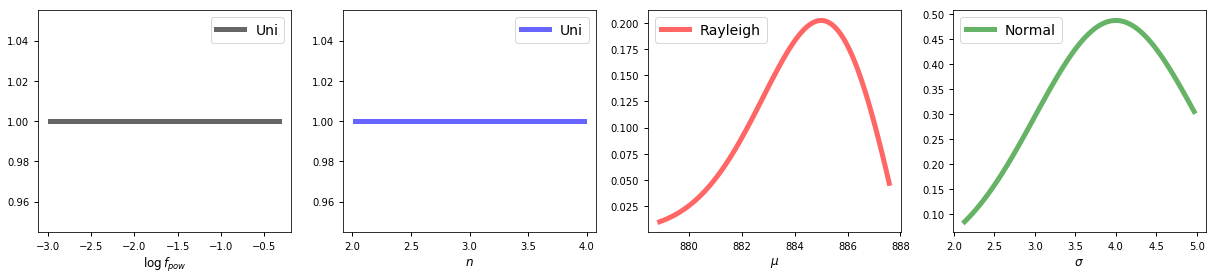

In [17]:
############################################
# Priors and Likelihood Models for Fitting
############################################

import dynesty
import time
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import multiprocess as mp

# truths = np.log10(frac), n, mu, sigma
labels = [r'$\log\,f_{pow}$', r'$n$', r'$\mu$', r'$\sigma$']
# labels = [r'$f_{pow}$', r'$n$', r'$\mu$', r'$\sigma$']
# print("Truths: ", np.around(truths, 3))

def prior_transform(u):
    v = u.copy()
    v[0] = u[0] * 1.7 - 2 # frac : 0.01-0.5
    v[1] = u[1] * 2 + 2  # n : 2-4
    v[2] = 888 - stats.rayleigh.ppf(u[2], loc=0, scale=3.)  # mu : peak around 884
    v[3] = stats.truncnorm.ppf(u[3], a=-2, b=1, loc=4, scale=1)  # sigma : N(4, 1)
    return v

if draw:
    dist1=stats.uniform()
    dist2=stats.rayleigh(loc=0, scale=3)
    dist3=stats.truncnorm(a=-2, b=1, loc=4, scale=1)

    x0,x1,x2,x3 = [np.linspace(d.ppf(0.01), d.ppf(0.99), 100) for d in (dist1,dist1,dist2,dist3)]

    fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(17,4))
    ax0.plot((x0 * 2.7 - 3), dist1.pdf(x0),'k-', lw=5, alpha=0.6, label='Uni')
    ax1.plot(x1*2+2, dist1.pdf(x1),'b-', lw=5, alpha=0.6, label='Uni')
    ax2.plot(888-x2, dist2.pdf(x2),'r-', lw=5, alpha=0.6, label='Rayleigh')
    ax3.plot(x3, dist3.pdf(x3),'g-', lw=5, alpha=0.6, label='Normal')
    for ax, xlab in zip((ax0,ax1,ax2,ax3), ["$\log\,f_{pow}$", "$n$", "$\mu$", "$\sigma$"]):
        ax.legend()
        ax.set_xlabel(xlab, fontsize=12)
    plt.tight_layout()
    if save:
        plt.savefig("%s/Prior.png"%dir_name,dpi=150)
        plt.close('all')
        

if mask_strip is True:
    mask_fit = mask_comb
else:
    mask_fit = mask_deep
    
X = np.array([xx,yy])
Y = image[~mask_fit].copy().ravel()

def loglike(v):
    logfrac, n, mu, sigma = v
    frac = 10**logfrac
    
    image_tri = generate_image_galsim_norm(frac, n, mu, sigma, star_pos=star_pos, norm=z_norm,
                                           image_size=image_size, parallel=True)
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike

def Run_Nested_Fitting(loglike=loglike, prior_transform=prior_transform, ndim=4,
                       nlive_init=200, nlive_batch=100, maxbatch=3,
                       print_progress=print_progress):
        
    with mp.Pool(processes=n_cpu-1) as pool:
        print("Opening pool: # of CPU used: %d"%(n_cpu))
        pool.size = n_cpu

        dlogz = 1e-3 * (nlive_init - 1) + 0.01

        pdsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim,
                                                  pool=pool, use_pool={'update_bound': False})
        pdsampler.run_nested(nlive_init=nlive_init, 
                             nlive_batch=nlive_batch, 
                             maxbatch=maxbatch,
                             print_progress=print_progress, 
                             dlogz_init=dlogz, 
                             wt_kwargs={'pfrac': 0.8})
    return pdsampler

Opening pool: # of CPU used: 3


iter: 6147 | batch: 3 | bound: 57 | nc: 1 | ncall: 20763 | eff(%): 29.606 | loglstar: -508931.965 < -508927.720 < -508929.576 | logz: -508948.041 +/-  0.425 | stop:  2.976                           


Finish Fitting! Total time elapsed: 2.97e+03s


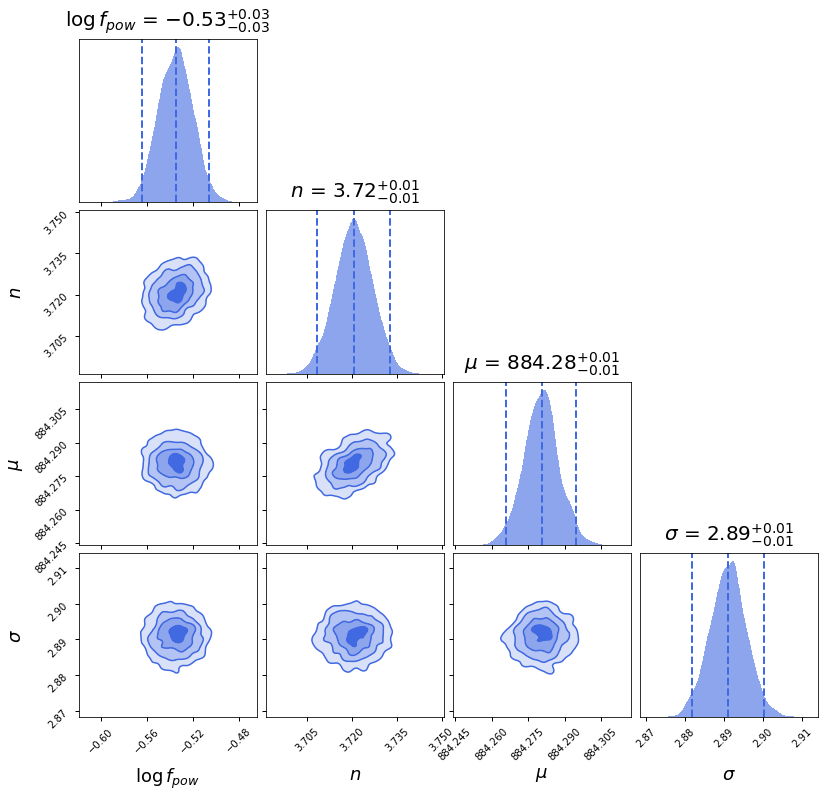

In [18]:
############################################
# Fitting
############################################

if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Nested_Fitting(loglike, prior_transform)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results
    if save:
        save_nested_fitting_result(pdres, filename='./%s/fit_real.res'%dir_name)

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, show_titles=True, 
                                  color="royalblue", labels=labels,
                                  title_kwargs={'fontsize':20, 'y': 1.04}, 
                                  label_kwargs={'fontsize':18},
                                  fig=plt.subplots(4, 4, figsize=(12, 11)))
    if save:
        plt.savefig("%s/Result.png"%dir_name,dpi=150)
        plt.close('all')

In [31]:
save_nested_fitting_result(pdres, filename='./%s/fit_real.res'%dir_name)

(-7, -1)

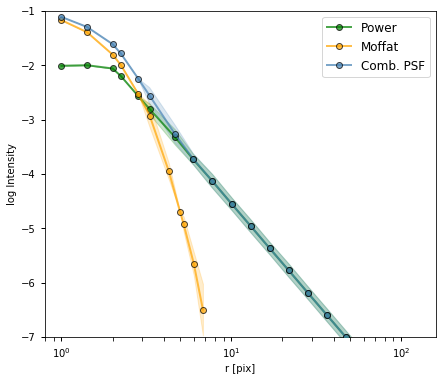

In [19]:
psf_pow_fit, _ = Generate_PSF_pow_Galsim(contrast=1e4, n=3.65,
                                        psf_size=image_size, 
                                        psf_scale=psf_pixel_scale)
frac = 10**-0.57
star_psf_fit = (1-frac) * psf_mof + frac * psf_pow_fit 
    
img_pow_fit = psf_pow_fit.drawImage(nx=image_size//2+1, ny=image_size//2+1, 
                                    scale=pixel_scale, method="no_pixel").array
img_mof = psf_mof.drawImage(nx=19, ny=19, scale=pixel_scale, method="no_pixel").array
img_gs_fit = star_psf_fit.drawImage(nx=image_size//2+1, ny=image_size//2+1, 
                                    scale=pixel_scale, method="no_pixel").array

plt.figure(figsize=(7,6))

r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(frac*img_pow_fit, pix_scale=pixel_scale, seeing=2.5, color="g",
                                             core_undersample=True,xunit="pix", yunit="intensity",label="Power")
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d((1-frac)*img_mof, pix_scale=pixel_scale, seeing=2.5, color="orange",
                                             core_undersample=True,xunit="pix", yunit="intensity",label="Moffat")
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_gs_fit, pix_scale=pixel_scale, seeing=2.5,  
                                             core_undersample=True,xunit="pix", yunit="intensity",label="Comb. PSF")
plt.xscale("log")
plt.legend(fontsize=12)
plt.ylim(-7,-1)

Fitting (mean):  [-5.34997183e-01  3.72064412e+00  8.84280434e+02  2.89110861e+00]
Fitting (median):  [-5.34871608e-01  3.72067060e+00  8.84280628e+02  2.89117917e+00]


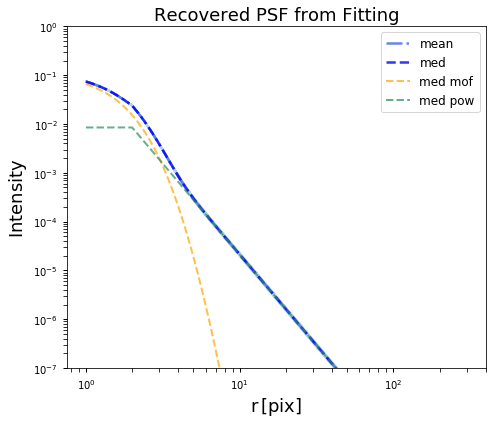

In [30]:
plot_fit_PSF(pdres, n_bootstrap=500, image_size=image_size)

In [ ]:
def plot_fit_PSF(res, image_size=image_size, 
                 n_bootstrap=200, save=False, dir_name="."):

    samples = res.samples                                 # samples
    weights = np.exp(res.logwt - res.logz[-1])            # normalized weights 
    pmean, pcov = dyfunc.mean_and_cov(samples, weights)     # weighted mean and covariance
    samples_eq = dyfunc.resample_equal(samples, weights)  # resample weighted samples
    pmed = np.median(samples_eq,axis=0)                    # median sample
    
    print("Fitting (mean): ", pmean)
    print("Fitting (median): ", pmed)
    
    from astropy.stats import bootstrap
    samples_eq_bs = bootstrap(samples_eq, bootnum=1, samples=n_bootstrap)[0]
    
    c_mof2Dto1D =  C_mof2Dto1D(gamma_pix, beta_psf)
    c_pow2Dto1D = C_pow2Dto1D(n, theta_t_pix)
    
    r = np.logspace(0., np.log10(image_size//2), 100)
    comp1 = moffat1d_normed(r, gamma=gamma_pix, alpha=beta_psf) / c_mof2Dto1D
    
    plt.figure(figsize=(7,6))
    
    for (logfrac_k, n_k, _, _) in samples_eq_bs:
        frac_k = 10**logfrac_k
        comp2_k = trunc_power1d_normed(r, n_k, theta_t_pix) / c_pow2Dto1D

        plt.semilogy(r, (1-frac_k) * comp1 + frac_k * comp2_k,
                     color="lightblue", lw=1.5,alpha=0.1,zorder=1)
    else:
        for fits, c, ls, l in zip([pmed, pmean], ["royalblue", "b"],
                                  ["-.","--"], ["mean", "med"]):
            f_fit = 10**fits[0]
            comp2 = trunc_power1d_normed(r, fits[1], theta_t_pix) / c_pow2Dto1D
            y_fit = (1-f_fit) * comp1 + f_fit * comp2
            
            plt.semilogy(r, y_fit, color=c, lw=2.5, ls=ls, alpha=0.8, label=l, zorder=4)
            if l=="med":
                plt.semilogy(r, (1-f_fit) * comp1,
                             color="orange", lw=2, ls="--", alpha=0.7, label="med mof",zorder=4)
                plt.semilogy(r, f_fit * comp2,
                             color="seagreen", lw=2, ls="--", alpha=0.7, label="med pow",zorder=4)
    
    plt.legend(fontsize=12)    
    plt.xlabel(r"$\rm r\,[pix]$",fontsize=18)
    plt.ylabel(r"$\rm Intensity$",fontsize=18)
    plt.title("Recovered PSF from Fitting",fontsize=18)
    plt.xscale("log")
    plt.ylim(1e-7, 1)    
    plt.tight_layout()
    if save:
        plt.savefig("%s/Fit_PSF.png"%dir_name,dpi=150)
        plt.close()